In [1]:
# Imported required packages
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import List
from tqdm import tqdm

import math
import random
import numpy as np
import pandas as pd
from scipy.stats import beta
import matplotlib.pyplot as plt


# Setting plot size, plot style & random seed
plt.rcParams["figure.figsize"] = (20,10)
plt.style.use('ggplot')
random.seed(1)

c:\Users\alif8\anaconda3\envs\main1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class BanditAlgorithm(ABC):
    """
    Abstract class to capture common behaviours among different types of bandit algorithms.
    
    As much as possible, NumPy operations are used to improve runtime.
    
    select_arm will depend on specific bandit algorithm and is left as an abstract method.
    """
    
    def set_arms(self, n_arms: int) -> BanditAlgorithm:
        """
        Method to set counts & values if previously not initialised
        
        :param n_arms: Number of arms in the simulation
        :return: Self
        """
        self.counts = np.full(n_arms, 0, dtype=int)
        self.values = np.full(n_arms, 0.0)
        return self
    
    @abstractmethod
    def select_arm(self) -> int:
        """
        Method to select arm
        
        :return: Index of chosen arm
        """
        pass
    
    def update(self, chosen_arm: int, reward: float) -> BanditAlgorithm:
        """
        Method to update counts & values after choosing an arm and obtaining a reward
        
        :param chosen_arm: Index of chosen arm
        :param reward: Reward earned from arm
        :return: Self
        """
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        
        new_value = (((n - 1) / float(n)) * value) + ((1 / float(n)) * reward)
        self.values[chosen_arm] = new_value
        return self
    
    def __str__(self) -> str:
        # Return name of algorithm, for plotting graphs
        return self.__class__.__name__                                    

In [3]:
class EpsilonGreedy(BanditAlgorithm):
    """
    Epsilon-Greedy bandit algorithm
    """
    
    def __init__(self, epsilon: float = 0.1) -> None:
        # Default epsilon is 0.1
        self.epsilon = epsilon
        return
    
    def select_arm(self) -> int:
        # Observe if this step will be exploration or exploitation
        if random.random() > self.epsilon:
            # If exploit, select best arm
            return np.argmax(self.values)
        else:
            # If explore, select random arm
            return random.randrange(len(self.values))
    
    def __str__(self) -> str:
        # Case when if epsilon is 1, choice will always be random
        if math.isclose(self.epsilon, 1.0):
            return "Randomly choose one arm at each step"
        # Case when if epsilon is 0, it becomes greedy algorithm 
        if math.isclose(self.epsilon, 0.0):
            return "Greedy algorithm"
        return super().__str__() + f" with epsilon={self.epsilon}"

In [4]:
class EpsilonDecay(BanditAlgorithm):
    """
    Epsilon-Decay bandit algorithm
    """
    
    def select_arm(self) -> int:
        # Calculate epsilon
        epsilon = 1 / ((sum(self.counts) / len(self.counts)) + 1)
        
        # Observe if this step will be exploration or exploitation
        if random.random() > epsilon:
            # If exploit, select best arm
            return np.argmax(self.values)
        else:
            # If explore, select random arm
            return random.randrange(len(self.values))

In [5]:
class Softmax(BanditAlgorithm):
    """
    Softmax bandit algorithm
    """
    
    def __init__(self, tau: float = 0.1) -> None:
        # Default temperature is 0.1
        self.tau = tau
        return
    
    def select_arm(self) -> int:
        # Calcualte proability
        exp_vals = np.exp(self.values / self.tau)
        pi = exp_vals / np.sum(exp_vals)
        
        # Draw arm based on probability
        choice = np.random.choice(len(self.values), p=pi)
        return choice
    
    def __str__(self) -> str:
        return super().__str__() + f" with temperature={self.tau}"

In [6]:
class AnnealingSoftmax(BanditAlgorithm):
    """
    Annealing softmax bandit algorithm
    """
    
    def select_arm(self) -> int:
        # Calculate temperature
        tau = 1 / ((sum(self.counts) / len(self.counts)) + 1)
        
        # Calcualte proability
        exp_vals = np.exp(self.values / tau)
        pi = exp_vals / np.sum(exp_vals)
        
        # Draw arm based on probability
        choice = np.random.choice(len(self.values), p=pi)
        return choice

In [7]:
class UCB(BanditAlgorithm):
    """
    Upper confidence bound bandit algorithm
    """
    
    def select_arm(self) -> int:
        # Ensure that each arm has been played at least once
        for arm, count in enumerate(self.counts):
            if count == 0:
                return arm     

        total_count = sum(self.counts)
        # Calculate curiousity bonus which allows for exploration
        bonus = np.sqrt(2 * np.log(total_count) / self.counts)
        # Calculate the ucb of each arm
        ucb_values = self.values + bonus
        
        # Return arm with highest ucb
        return np.argmax(ucb_values)

In [8]:
class BetaBandit(BanditAlgorithm):
    """
    Abstract bandit algorithm class for BayesianUCB & Thompson Sampling, both utilise Beta distribution for prior distribution
    """
    
    def __init__(self
                 , prior_alpha: float = 1.0
                 , prior_beta: float = 1.0
                 ) -> None:
        super().__init__()
        # Default is the use uniform prior
        self.prior_alpha = prior_alpha
        self.prior_beta = prior_beta
        return
    
    def set_arms(self, n_arms: int) -> BanditAlgorithm:
        self.alphas = np.full(n_arms, self.prior_alpha)
        self.betas = np.full(n_arms, self.prior_beta)
        super().set_arms(n_arms)
        return self
    
    def update(self, chosen_arm: int, reward: float) -> BanditAlgorithm:
        # Updating counts & values
        super().update(chosen_arm, reward)
        # Updating alphas & betas
        self.alphas[chosen_arm] += reward
        self.betas[chosen_arm] += (1 - reward)
        return self

In [9]:
class BayesianUCB(BetaBandit):
    """
    Bayesian upper confidence bound bandit algorithm
    """
    
    def __init__(self
                 , prior_alpha: float = 1.0
                 , prior_beta: float = 1.0
                 , stdnum: float = 3.0
                 ) -> None:
        super().__init__(prior_alpha, prior_beta)
        self.stdnum = stdnum
        return
    
    def select_arm(self) -> int:
        # Calculate the ucb of each arm
        
        # Calculate mean of beta distribution
        expected_rewards = self.alphas / (self.alphas + self.betas)
        # Calculate curiousity bonus which allows for exploration
        bonus = beta.std(self.alphas, self.betas) * self.stdnum
        ucb_values = expected_rewards + bonus
        
        # Return arm with highest ucb
        return np.argmax(ucb_values)
    
    def __str__(self) -> str:
        return super().__str__() + f" with stdnum={self.stdnum}"

In [10]:
class ThompsonSampling(BetaBandit):
    """
    Thompson sampling bandit algorithm
    """
    
    def select_arm(self) -> int:
        # Calculate theta values for each arm
        theta_values = np.random.beta(self.alphas, self.betas)
        
        # Return arm with highest theta
        return np.argmax(theta_values)

In [11]:
class ContextualBandit(BanditAlgorithm):
    """
    Abstract class for contextual bandits, select_arm and update methods take an additional input, context.
    """
    
    def set_arms(self, n_arms: int, n_features: int) -> BanditAlgorithm:
        self.n_features = n_features
        
        # A stores covariance matrix of features seen by arm, initialised as identity matrix
        self.A = np.tile(np.eye(n_features), (n_arms, 1, 1))
        # b stores sum of rewards, or 'Y' in the case of a linear model, for each arm
        self.b = np.zeros((n_arms, n_features))
        return self
    
    @abstractmethod
    def select_arm(self, context: np.ndarray) -> int:
        pass
    
    def update(self
               , chosen_arm: int
               , reward: float
               , context: np.ndarray
               ) -> BanditAlgorithm:
        # Updating A and b
        self.A[chosen_arm] += np.outer(context, context)
        self.b[chosen_arm] += reward * context
        return self

In [12]:
class LinUCB(ContextualBandit):
    """
    Linear UCB contextual bandit algorithm
    """
    
    def __init__(self, alpha: float = 0.1) -> None:
        # alpha will determine level of exploration, default is 0.1
        self.alpha = alpha
        return
    
    def set_arms(self
                 , n_arms: int
                 , n_features: int
                 ) -> BanditAlgorithm:  
        
        super().set_arms(n_arms, n_features)
        
        # theta refers to the regression coefficients, recall OLS solution
        # theta does not change at each call to select_arm, as it does not depend on context, so we can store as attribute to avoid duplicate computations
        self.theta = np.zeros((n_arms, n_features))
        
        return self
    
    def select_arm(self, context: np.ndarray) -> int:
        n_arms = self.A.shape[0]
        p_arms = np.zeros(n_arms)
        
        for arm in range(n_arms):
            # Calculating scores for each arm's linear model, including exploration bonus
            p_arms = (
                (context @ self.theta[arm]) 
                + (self.alpha * 
                    np.sqrt(context.transpose() 
                            @ np.linalg.inv(self.A[arm])
                            @ context))
            )
        # Return arm with highest score
        return np.argmax(p_arms)
    
    def update(self
               , chosen_arm: int
               , reward: float
               , context: np.ndarray
               ) -> BanditAlgorithm:
        super().update(chosen_arm, reward, context)
        
        # Getting inverse of the covariance matrix of chosen arm's linear model
        A_inv = np.linalg.inv(self.A[chosen_arm])
        # Calculating weight vector for chosen arm's linear model
        self.theta[chosen_arm] = A_inv @ self.b[chosen_arm]
        return self
    
    def __str__(self) -> str:
        return super().__str__() + f" with alpha={self.alpha}"

In [13]:
class ContextualThompsonSampling(ContextualBandit):
    """
    Contextual Thompson Sampling with linear payoff
    """
    
    def __init__(self
                 , delta: float = 0.1
                 , epsilon: float = 0.1
                 , R: float = 0.01
                 ) -> None:
        self.delta = delta
        self.epsilon = epsilon
        self.R = R
        return
    
    def set_arms(self, n_arms: int, n_features: int) -> BanditAlgorithm:
        super().set_arms(n_arms, n_features)
        
        # v is fixed, we can store as attribute to avoid duplicate computations
        self.v = self.R * np.sqrt(
                24 / self.epsilon * self.n_features * np.log(1 / self.delta)
            )
        # mu_hat does not change at each call to select_arm, as it does not depend on context, so we can store as attribute to avoid duplicate computations
        self.mu_hat = np.zeros((n_arms, n_features))
        return self
    
    def select_arm(self, context: np.ndarray) -> int:
        n_arms = self.A.shape[0]
        scores = np.zeros(n_arms)
        
        for arm in range(n_arms):
            # Sampling mu_tilde for Gaussian distribution, exploration bonus arises from v
            mu_tilde = np.random.multivariate_normal(
                self.mu_hat[arm], (self.v ** 2) * np.linalg.inv(self.A[arm])
                )
            # Calculating score for each arm
            scores[arm] = context.transpose() @ mu_tilde
        
        # Return arm with highest score
        return np.argmax(scores)
    
    def update(self
               , chosen_arm: int
               , reward: float
               , context: np.ndarray
               ) -> BanditAlgorithm:
        super().update(chosen_arm, reward, context)
        
        # Getting inverse of the covariance matrix of chosen arm
        A_inv = np.linalg.inv(self.A[chosen_arm])
        # Calculating mu_hat for chosen arm
        self.mu_hat[chosen_arm] = A_inv @ self.b[chosen_arm]
        return self
    
    def __str__(self) -> str:
        return super().__str__() + f" with delta={self.delta}, epsilon={self.epsilon}, R={self.R}"

In [17]:
def evaluation_replay(
    algos: List[BanditAlgorithm]
    , data: pd.DataFrame
    , context_cols: List[str]
    , best_business_id: str
    ) -> pd.DataFrame:
    """
    Function to perform evaluation replay with multiple bandit algorithms, including contextual bandits
    
    Results will contain policy, reward, cumulative reward for each time step
    
    :param algos: List of bandit algorithms to run
    :param data: DataFrame with 'business_id' as arm, 'stars' as reward
    :param context_cols: List of column names of the context features
    :param best_business_id: String containing business id that has highest average score
    :return: DataFrame containg results
    """
    
    # Count number of reviews
    n = data.shape[0]
    # Count number of arms
    n_arms = data['business_id'].nunique()
    results = []
    # Excluding all non-context columns
    context_df = data[context_cols]
    # Count number of features
    n_features = context_df.shape[1]
    
    # Note that bandit algorithms use arm as indexes, so we need to factorize 'business_id' into integer keys
    arm_id_series, business_id_order = pd.factorize(data['business_id'])
    data['arm_id'] = arm_id_series
    
    # Randomly shuffle data, as original data was in sequence of business_id
    data = data.sample(frac=1).reset_index(drop=True)
    
    for algo in algos:
        # Initialising arms
        if isinstance(algo, ContextualBandit):
            algo.set_arms(n_arms, n_features)
        else:
            algo.set_arms(n_arms)
        
        cumulative_reward = 0.0
        for t in tqdm(range(n), desc=f'Running {str(algo)}'):
            # Extract context at current time step
            context = context_df.iloc[t].to_numpy()
            
            # Draw arm
            if isinstance(algo, ContextualBandit):
                chosen_arm = algo.select_arm(context)
            else:
                chosen_arm = algo.select_arm()
            
            # Compare to actual arm
            actual_arm = data.iloc[t]['arm_id']
            if chosen_arm == actual_arm:
                # Update algorithm with reward if chosen arm matches actual arm
                reward = data.iloc[t]['stars']
                if isinstance(algo, ContextualBandit):
                    algo.update(chosen_arm, reward, context)
                else:
                    algo.update(chosen_arm, reward)
                
                # Updating cumulative reward
                cumulative_reward += reward
                
                # Appending results at current step
                current_step = {
                    'policy': str(algo),
                    'time_step': t,
                    'business_id': data.iloc[t]['business_id'],
                    'reward': reward,
                    'cumulative_reward': cumulative_reward
                }
                results.append(current_step)
    
    results_df = pd.DataFrame(results)
    # Calculating average reward
    results_df['average_reward'] = (
        results_df['cumulative_reward'] / (results_df['time_step'] + 1)
        ).fillna(value=0.0)
    return results_df
                

In [18]:
def present_results(data: pd.DataFrame, target_metric: str) -> None:
    """
    Helper function to plot results, x-axis will be time_step
    
    :param data: DataFrame containg results of simulation
    :param target_metric: Metric to plot on y-axis
    """
    fig, ax = plt.subplots()
    # Set of colors for plot labels
    colors = ['b', 'g', 'r', 'c', 'm', 'k', 'yellow', 'darkorange', 'blueviolet', 'lime', 'slategrey', 'hotpink', 'maroon', 'deepskyblue']
    
    # Collect names of algorithm
    algo_names = data['policy'].unique().tolist()
    for i, algo_name in enumerate(algo_names):      
        
        # Filter results for that algorithm
        algo_result = data[data['policy'] == algo_name]
        ax.plot(
            algo_result['time_step']
            , algo_result[target_metric]
            , label=algo_name
            , color=colors[i])
    plt.legend()
    plt.title(f"{target_metric} at each step")

In [19]:
data = pd.read_csv('lasvegas_reviews_with_features.csv')
print(data.shape)
data.head()

(246483, 56)


,Unnamed: 0.1,Unnamed: 0,review_id,user_id,business_id,date,text,useful,funny,cool,...,address,city,state,postal_code,latitude,longitude,stars_y,review_count,is_open,categories
0,0,0,gN6GARS_BRr5UX2D3WAH0w,nOTl4aPC4tKHK35T3bNauQ,xVEtGucSRLk5pxxN0t4i6g,2012-08-23,We got recommendations for this place from my ...,0,0,0,...,"""3655 Las Vegas Blvd S""",Las Vegas,NV,89109,36.112477,-115.172189,4.0,1549,1,Steakhouses;Nightlife;Bars;French;Restaurants;...
1,1,1,Qnc2zkr-ld9nDJTzXmc4WQ,C_CYs2G3UFPng3MupCe5eQ,xVEtGucSRLk5pxxN0t4i6g,2015-04-06,"I really wanted to love this place, but I just...",1,1,1,...,"""3655 Las Vegas Blvd S""",Las Vegas,NV,89109,36.112477,-115.172189,4.0,1549,1,Steakhouses;Nightlife;Bars;French;Restaurants;...
2,2,2,qicHEB75WFOr9d8LNHqE8Q,l0-VQ8nA_oijpKlRB7dkow,xVEtGucSRLk5pxxN0t4i6g,2010-02-11,A beautiful restaurant that you would expect t...,1,0,0,...,"""3655 Las Vegas Blvd S""",Las Vegas,NV,89109,36.112477,-115.172189,4.0,1549,1,Steakhouses;Nightlife;Bars;French;Restaurants;...
3,3,3,4rppwJJ15o7LcjxEARRcfA,APdqZ02n-0L0jKpQ9hn-BA,xVEtGucSRLk5pxxN0t4i6g,2016-06-27,"Enjoyed our food, flavorful. We had Creamed sp...",0,0,0,...,"""3655 Las Vegas Blvd S""",Las Vegas,NV,89109,36.112477,-115.172189,4.0,1549,1,Steakhouses;Nightlife;Bars;French;Restaurants;...
4,4,4,FqKmtB_jZPYDM9Bzx4PZEQ,DQYMtGFO1-DUGB0yX3a4Qg,xVEtGucSRLk5pxxN0t4i6g,2010-03-15,My husband (fiance at the time) had our last m...,0,0,0,...,"""3655 Las Vegas Blvd S""",Las Vegas,NV,89109,36.112477,-115.172189,4.0,1549,1,Steakhouses;Nightlife;Bars;French;Restaurants;...


In [20]:
# Extracting context columns
context_cols = ['American',
       'Asian Fusion', 'Bakeries', 'Bars', 'Breakfast & Brunch', 'British',
       'Buffets', 'Burgers', 'Caribbean', 'Cafes', 'Caterers', 'Chinese',
       'Desserts', 'French', 'German', 'Gluten-Free', 'Indian', 'Hawaiian',
       'Italian', 'Japanese', 'Korean', 'Latin American', 'Mediterranean',
       'Mexican', 'Music Venues', 'Nightlife', 'Seafood', 'Salad', 'Spanish',
       'Thai', 'Vegan', 'Vegetarian', 'Vietnamese']
# Extracting other relevant columns
relevant_cols = ['review_id', 'user_id', 'business_id', 'date', 'text', 'stars_x']
relevant_cols.extend(context_cols)
# Renaming columns
data_df = data[relevant_cols].rename(
           columns={
               'stars_x': 'stars'
           }
       )

In [23]:
# Initialise all the algorithms to run
algos = [
    EpsilonGreedy(epsilon=0.0)
    , EpsilonGreedy(epsilon=1.0)
    , EpsilonGreedy(epsilon=0.1)
    , EpsilonDecay()
    , Softmax(tau=0.1)
    , AnnealingSoftmax()
    , UCB()
    , BayesianUCB()
    , ThompsonSampling()
    , LinUCB()
    , ContextualThompsonSampling()
]
results = evaluation_replay(algos, data_df, context_cols, best_business_id)

Running LinUCB with alpha=0.1: 100%|██████████| 246483/246483 [1:03:53<00:00, 64.30it/s] 
Running ContextualThompsonSampling with delta=0.1, epsilon=0.1, R=0.01: 100%|██████████| 246483/246483 [8:02:08<00:00,  8.52it/s]    


In [28]:
# Save results as csv
results.to_csv('results.csv')
results

,policy,time_step,business_id,reward,cumulative_reward,average_reward,if_best_arm,prob_best_arm
0,Greedy algorithm,92,xVEtGucSRLk5pxxN0t4i6g,0,0.0,0.000000,0,0.000000
1,Greedy algorithm,161,xVEtGucSRLk5pxxN0t4i6g,0,0.0,0.000000,0,0.000000
2,Greedy algorithm,173,xVEtGucSRLk5pxxN0t4i6g,1,1.0,0.005747,0,0.000000
3,Greedy algorithm,504,xVEtGucSRLk5pxxN0t4i6g,1,2.0,0.003960,0,0.000000
4,Greedy algorithm,630,xVEtGucSRLk5pxxN0t4i6g,0,2.0,0.003170,0,0.000000
...,...,...,...,...,...,...,...,...
18403,"ContextualThompsonSampling with delta=0.1, eps...",245348,yfxDa8RFOvJPQh0rNtakHA,0,1176.0,0.004793,0,0.000033
18404,"ContextualThompsonSampling with delta=0.1, eps...",245568,5shgJB7a-2_gdnzc0gsOtg,1,1177.0,0.004793,0,0.000033
18405,"ContextualThompsonSampling with delta=0.1, eps...",245654,K7lWdNUhCbcnEvI0NhGewg,1,1178.0,0.004795,0,0.000033
18406,"ContextualThompsonSampling with delta=0.1, eps...",246087,IWN2heYitkg-D4UdqfxcMA,0,1178.0,0.004787,0,0.000033


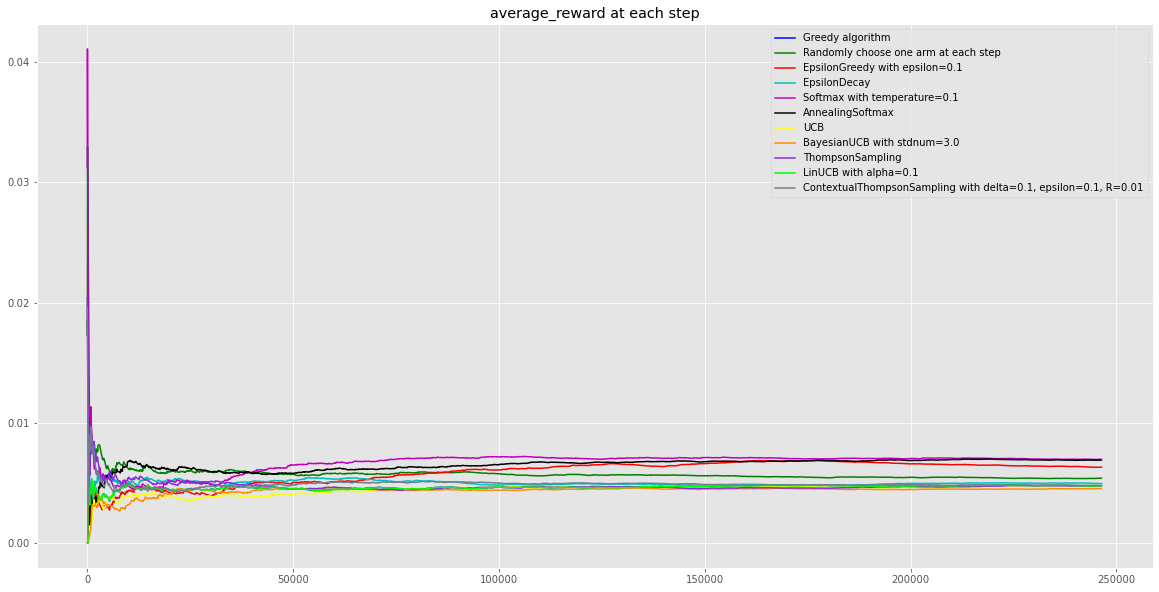

In [29]:
present_results(results, 'average_reward')

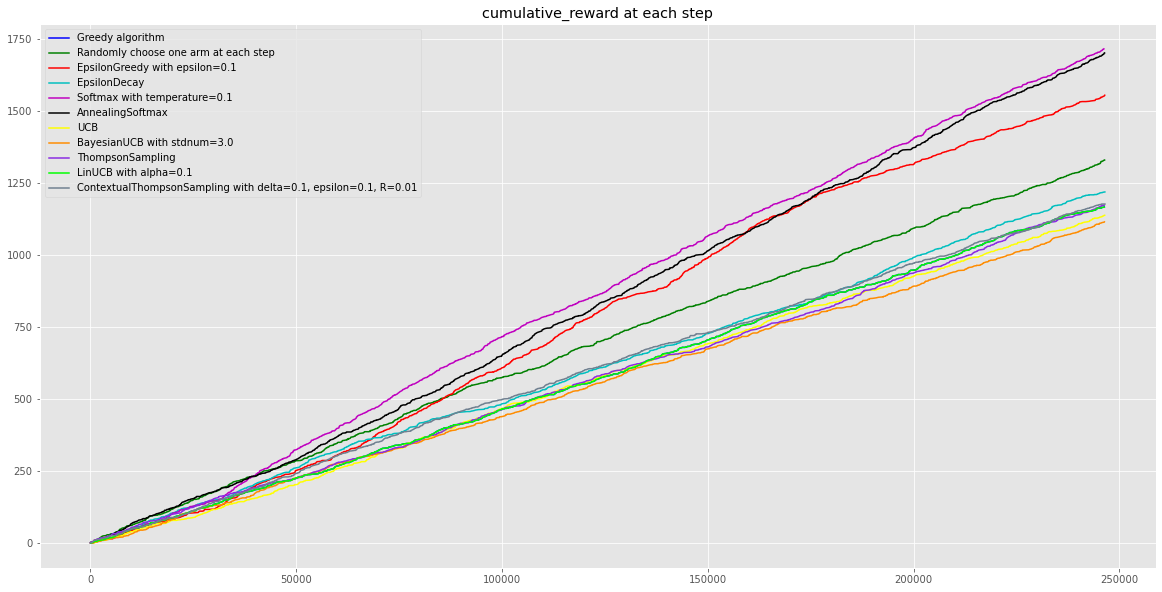

In [30]:
present_results(results, 'cumulative_reward')